<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching_vols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import sys
sys.path.append('/content/drive/My Drive')

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
# Imports for stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from alphaRNN import *
from keras.layers import Layer
from keras import backend as K
from keras import layers
import keras.layers
#from alphaRNN import *
from keras import *
from keras.legacy import interfaces
from sklearn.preprocessing import StandardScaler

	
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
# To make this notebook's output stable across runs
#def reset_graph(seed=42):
#    tf.reset_default_graph()
#    tf.set_random_seed(seed)
#    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Using TensorFlow backend.


In [0]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
np.random.seed(0)

In [0]:
p = 30 # the number of lags (in both the data and the models)
vols=generate_vol_sample(20000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]


In [0]:
df = pd.DataFrame(vols, columns=['vol'])

In [0]:
use_features = ['vol'] 
target = 'vol'
n_steps = 20 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
print(df_train)
df_test = df[use_features].iloc[split:]

            vol
0      0.232180
1      0.234084
2      0.236225
3      0.238478
4      0.240610
...         ...
15971  0.129943
15972  0.129881
15973  0.130022
15974  0.129987
15975  0.130003

[15976 rows x 1 columns]


In [0]:
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df[target][:2000])
print(adf,p, nobs, cvs)

-3.2810394829898897 0.01574757804048544 1999 {'1%': -3.4336254962865045, '5%': -2.862986937508278, '10%': -2.567540287745173}


In [0]:
pacf=sm.tsa.stattools.pacf(df['vols'], nlags=30)
n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df_p)))==False)[0][0] -1
print(n_steps)

In [0]:
def get_lagged_features(value, n_steps,n_steps_ahead):
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
n_steps_ahead=10

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(1547, 20, 1) (1547, 1, 1) (365, 20, 1) (365, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [0]:
print(train_batch_size)

1547


In [0]:
class AlphaRNNCell(Layer):
    """Cell class for AlphaRNN.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
    """

    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 **kwargs):
        super(AlphaRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        #self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        self.alpha = self.add_weight(shape=(1,),
                                        name='alpha',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        self.built = True

    def call(self, inputs, states, training=None):
        prev_output = states[0]
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(prev_output),
                self.recurrent_dropout,
                training=training)

        dp_mask = self._dropout_mask
        rec_dp_mask = self._recurrent_dropout_mask

        if dp_mask is not None:
            h = K.dot(inputs * dp_mask, self.kernel)
        else:
            h = K.dot(inputs, self.kernel)
        if self.bias is not None:
            h = K.bias_add(h, self.bias)

        if rec_dp_mask is not None:
            prev_output *= rec_dp_mask
        output = h + K.dot(prev_output, self.recurrent_kernel)
        if self.activation is not None:
            output = self.activation(output)
        output = K.sigmoid(self.alpha)* output + (1-K.sigmoid(self.alpha))* prev_output
        # Properly set learning phase on output tensor.
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                output._uses_learning_phase = True
        return output, [output]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
 class AlphaRNN(keras.layers.RNN):
    """Fully-connected AlphaRNN where the output is to be fed back to input.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if 'implementation' in kwargs:
            kwargs.pop('implementation')
            warnings.warn('The `implementation` argument '
                          'in `SimpleRNN` has been deprecated. '
                          'Please remove it from your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphaRNNCell(units,
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             recurrent_initializer=recurrent_initializer,
                             bias_initializer=bias_initializer,
                             kernel_regularizer=kernel_regularizer,
                             recurrent_regularizer=recurrent_regularizer,
                             bias_regularizer=bias_regularizer,
                             kernel_constraint=kernel_constraint,
                             recurrent_constraint=recurrent_constraint,
                             bias_constraint=bias_constraint,
                             dropout=dropout,
                             recurrent_dropout=recurrent_dropout)
        super(AlphaRNN, self).__init__(cell,
                                        return_sequences=return_sequences,
                                        return_state=return_state,
                                        go_backwards=go_backwards,
                                        stateful=stateful,
                                        unroll=unroll,
                                        **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphaRNN, self).call(inputs,
                                           mask=mask,
                                           training=training,
                                           initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config:
            config.pop('implementation')
        return cls(**config)

In [0]:
class AlphatRNNCell(Layer):
    """Cell class for the AlphatRNN layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(AlphatRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 2),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 2),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            bias_shape = (2, 2*self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            
            self.input_bias = K.flatten(self.bias[0])
            self.recurrent_bias = K.flatten(self.bias[1])
        else:
            self.bias = None

        # alpha
        self.kernel_alpha = self.kernel[:, :self.units]
        self.recurrent_kernel_alpha = self.recurrent_kernel[:, :self.units]
        # recurrnce
        self.kernel_h = self.kernel[:, self.units:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units:]

        if self.use_bias:
            # bias for inputs
            self.input_bias_alpha = self.input_bias[:self.units]
            self.input_bias_h = self.input_bias[self.units:]
            # bias for hidden state - just for compatibility with CuDNN
            
            self.recurrent_bias_alpha = self.recurrent_bias[:self.units]    
            self.recurrent_bias_h = self.recurrent_bias[self.units:]
        else:
            self.input_bias_alpha = None
            self.input_bias_h = None
            
            self.recurrent_bias_alpha = None
            self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=2)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=2)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_alpha = inputs * dp_mask[0]
                inputs_h = inputs * dp_mask[1]
            else:
                inputs_alpha = input
                inputs_h = inputs

            x_alpha = K.dot(inputs_alpha, self.kernel_alpha)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_alpha = K.bias_add(x_alpha, self.input_bias_alpha)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_alpha = h_tm1 * rec_dp_mask[0]
                h_tm1_h = h_tm1 * rec_dp_mask[1]
            else:
                h_tm1_alpha = h_tm1
                h_tm1_h = h_tm1

            recurrent_alpha = K.dot(h_tm1_alpha, self.recurrent_kernel_alpha)
           
            if self.use_bias:
                recurrent_alpha = K.bias_add(recurrent_alpha, self.recurrent_bias_alpha)

            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
           
            recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
            if self.use_bias:
                recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
            
            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_alpha = matrix_x[:, :self.units]
            x_h = matrix_x[:, self.units: 2 * self.units]
            
            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            
            matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                  matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            
            recurrent_alpha = matrix_inner[:, :self.units] 
            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
            recurrent_h = matrix_inner[:, self.units: 2 * self.units]  
            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = alpha * h_tm1 + (1 - alpha) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class AlphatRNN(keras.layers.RNN):
    """Alpha_t RNN
    There are two variants. The default one is based on 1406.1078v3 and
    has reset gate applied to hidden state before matrix multiplication. The
    other one is based on original 1406.1078v1 and has the order reversed.
    The second variant is compatible with CuDNNGRU (GPU-only) and allows
    inference on CPU. Thus it has separate biases for `kernel` and
    `recurrent_kernel`. Use `'reset_after'=True` and
    `recurrent_activation='sigmoid'`.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: sigmoid (`sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
        
    # References
        - [Learning Phrase Representations using RNN Encoder-Decoder for
           Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
        - [On the Properties of Neural Machine Translation:
           Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
        - [Empirical Evaluation of Gated Recurrent Neural Networks on
           Sequence Modeling](https://arxiv.org/abs/1412.3555v1)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphatRNNCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation)             
        super(AlphatRNN, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphatRNN, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [0]:

x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))



In [0]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-8, restore_best_weights=True)

In [0]:
def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNNt...")
model = KerasRegressor(build_fn=AlphaRNNt, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnnt = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for AlphaRNNt...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.7min finished


Epoch 1/2000
 - 5s - loss: 0.0423
Epoch 2/2000
 - 0s - loss: 0.0235
Epoch 3/2000
 - 0s - loss: 0.0204
Epoch 4/2000
 - 0s - loss: 0.0194
Epoch 5/2000
 - 0s - loss: 0.0183
Epoch 6/2000
 - 0s - loss: 0.0167
Epoch 7/2000
 - 0s - loss: 0.0135
Epoch 8/2000
 - 0s - loss: 0.0088
Epoch 9/2000
 - 0s - loss: 0.0077
Epoch 10/2000
 - 0s - loss: 0.0073
Epoch 11/2000
 - 0s - loss: 0.0070
Epoch 12/2000
 - 0s - loss: 0.0068
Epoch 13/2000
 - 0s - loss: 0.0066
Epoch 14/2000
 - 0s - loss: 0.0066
Epoch 15/2000
 - 0s - loss: 0.0063
Epoch 16/2000
 - 0s - loss: 0.0062
Epoch 17/2000
 - 0s - loss: 0.0060
Epoch 18/2000
 - 0s - loss: 0.0059
Epoch 19/2000
 - 0s - loss: 0.0058
Epoch 20/2000
 - 0s - loss: 0.0058
Epoch 21/2000
 - 0s - loss: 0.0058
Epoch 22/2000
 - 0s - loss: 0.0058
Epoch 23/2000
 - 0s - loss: 0.0057
Epoch 24/2000
 - 0s - loss: 0.0058
Epoch 25/2000
 - 0s - loss: 0.0057
Epoch 26/2000
 - 0s - loss: 0.0057
Epoch 27/2000
 - 0s - loss: 0.0056
Epoch 28/2000
 - 0s - loss: 0.0056
Epoch 29/2000
 - 0s - loss: 0

Epoch 232/2000
 - 0s - loss: 0.0026
Epoch 233/2000
 - 0s - loss: 0.0026
Epoch 234/2000
 - 0s - loss: 0.0027
Epoch 235/2000
 - 0s - loss: 0.0027
Epoch 236/2000
 - 0s - loss: 0.0028
Epoch 237/2000
 - 0s - loss: 0.0027
Epoch 238/2000
 - 0s - loss: 0.0030
Epoch 239/2000
 - 0s - loss: 0.0030
Epoch 240/2000
 - 0s - loss: 0.0026
Epoch 241/2000
 - 0s - loss: 0.0026
Epoch 242/2000
 - 0s - loss: 0.0026
Epoch 243/2000
 - 0s - loss: 0.0027
Epoch 244/2000
 - 0s - loss: 0.0026
Epoch 245/2000
 - 0s - loss: 0.0025
Epoch 246/2000
 - 0s - loss: 0.0025
Epoch 247/2000
 - 0s - loss: 0.0024
Epoch 248/2000
 - 0s - loss: 0.0024
Epoch 249/2000
 - 0s - loss: 0.0036
Epoch 250/2000
 - 0s - loss: 0.0053
Epoch 251/2000
 - 0s - loss: 0.0051
Epoch 252/2000
 - 0s - loss: 0.0052
Epoch 253/2000
 - 0s - loss: 0.0051
Epoch 254/2000
 - 0s - loss: 0.0050
Epoch 255/2000
 - 0s - loss: 0.0050
Epoch 256/2000
 - 0s - loss: 0.0049
Epoch 257/2000
 - 0s - loss: 0.0049
Epoch 258/2000
 - 0s - loss: 0.0049
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0025
Epoch 461/2000
 - 0s - loss: 0.0022
Epoch 462/2000
 - 0s - loss: 0.0022
Epoch 463/2000
 - 0s - loss: 0.0023
Restoring model weights from the end of the best epoch
Epoch 00463: early stopping
Best: -0.002483 using {'l1_reg': 0, 'n_units': 20}
-0.002998 (0.001797) with {'l1_reg': 0, 'n_units': 5}
-0.003723 (0.001437) with {'l1_reg': 0, 'n_units': 10}
-0.002483 (0.000902) with {'l1_reg': 0, 'n_units': 20}
-0.004345 (0.000957) with {'l1_reg': 0.001, 'n_units': 5}
-0.004057 (0.000872) with {'l1_reg': 0.001, 'n_units': 10}
-0.003489 (0.001461) with {'l1_reg': 0.001, 'n_units': 20}


In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]
tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNN...")
model = KerasRegressor(build_fn=Alpha_Rnn, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for AlphaRNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
exception calling callback for <Future at 0x14c226e80 state=finished raised BrokenProcessPool>
sklearn.externals.joblib.externals.loky.process_executor._RemoteTraceback: 
'''
Traceback (most recent call last):
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/macbookpro/anaconda3/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/engine/network.py", line 1266, in __setstate__
    model = saving.unpickle_model(state)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py", line 435, in unpickle_model
    return _deserialize_model(f)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-pac

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]
tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for Plain_RNN...")
model = KerasRegressor(build_fn=Plain_Rnn, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for Plain_RNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.9min finished


Epoch 1/2000
 - 3s - loss: 0.0249
Epoch 2/2000
 - 0s - loss: 0.0193
Epoch 3/2000
 - 0s - loss: 0.0181
Epoch 4/2000
 - 0s - loss: 0.0163
Epoch 5/2000
 - 0s - loss: 0.0137
Epoch 6/2000
 - 0s - loss: 0.0096
Epoch 7/2000
 - 0s - loss: 0.0086
Epoch 8/2000
 - 0s - loss: 0.0082
Epoch 9/2000
 - 0s - loss: 0.0081
Epoch 10/2000
 - 0s - loss: 0.0081
Epoch 11/2000
 - 0s - loss: 0.0080
Epoch 12/2000
 - 0s - loss: 0.0079
Epoch 13/2000
 - 0s - loss: 0.0079
Epoch 14/2000
 - 0s - loss: 0.0079
Epoch 15/2000
 - 0s - loss: 0.0078
Epoch 16/2000
 - 0s - loss: 0.0079
Epoch 17/2000
 - 0s - loss: 0.0077
Epoch 18/2000
 - 0s - loss: 0.0076
Epoch 19/2000
 - 0s - loss: 0.0076
Epoch 20/2000
 - 0s - loss: 0.0076
Epoch 21/2000
 - 0s - loss: 0.0076
Epoch 22/2000
 - 0s - loss: 0.0076
Epoch 23/2000
 - 0s - loss: 0.0077
Epoch 24/2000
 - 0s - loss: 0.0074
Epoch 25/2000
 - 0s - loss: 0.0073
Epoch 26/2000
 - 0s - loss: 0.0073
Epoch 27/2000
 - 0s - loss: 0.0073
Epoch 28/2000
 - 0s - loss: 0.0072
Epoch 29/2000
 - 0s - loss: 0

Epoch 232/2000
 - 0s - loss: 0.0052
Epoch 233/2000
 - 0s - loss: 0.0052
Epoch 234/2000
 - 0s - loss: 0.0052
Epoch 235/2000
 - 0s - loss: 0.0052
Epoch 236/2000
 - 0s - loss: 0.0052
Epoch 237/2000
 - 0s - loss: 0.0052
Epoch 238/2000
 - 0s - loss: 0.0052
Epoch 239/2000
 - 0s - loss: 0.0052
Epoch 240/2000
 - 0s - loss: 0.0052
Epoch 241/2000
 - 0s - loss: 0.0052
Epoch 242/2000
 - 0s - loss: 0.0052
Epoch 243/2000
 - 0s - loss: 0.0051
Epoch 244/2000
 - 0s - loss: 0.0051
Epoch 245/2000
 - 0s - loss: 0.0052
Epoch 246/2000
 - 0s - loss: 0.0052
Epoch 247/2000
 - 0s - loss: 0.0051
Epoch 248/2000
 - 0s - loss: 0.0051
Epoch 249/2000
 - 0s - loss: 0.0051
Epoch 250/2000
 - 0s - loss: 0.0051
Epoch 251/2000
 - 0s - loss: 0.0052
Epoch 252/2000
 - 0s - loss: 0.0051
Epoch 253/2000
 - 0s - loss: 0.0051
Epoch 254/2000
 - 0s - loss: 0.0051
Epoch 255/2000
 - 0s - loss: 0.0051
Epoch 256/2000
 - 0s - loss: 0.0051
Epoch 257/2000
 - 0s - loss: 0.0050
Epoch 258/2000
 - 0s - loss: 0.0050
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0026
Epoch 461/2000
 - 0s - loss: 0.0031
Epoch 462/2000
 - 0s - loss: 0.0027
Epoch 463/2000
 - 0s - loss: 0.0029
Epoch 464/2000
 - 0s - loss: 0.0028
Epoch 465/2000
 - 0s - loss: 0.0028
Epoch 466/2000
 - 0s - loss: 0.0028
Epoch 467/2000
 - 0s - loss: 0.0026
Epoch 468/2000
 - 0s - loss: 0.0028
Epoch 469/2000
 - 0s - loss: 0.0027
Epoch 470/2000
 - 0s - loss: 0.0026
Epoch 471/2000
 - 0s - loss: 0.0026
Epoch 472/2000
 - 0s - loss: 0.0026
Epoch 473/2000
 - 0s - loss: 0.0027
Epoch 474/2000
 - 0s - loss: 0.0028
Epoch 475/2000
 - 0s - loss: 0.0031
Epoch 476/2000
 - 0s - loss: 0.0034
Restoring model weights from the end of the best epoch
Epoch 00476: early stopping
Best: -0.002480 using {'l1_reg': 0.001, 'n_units': 20}
-0.003849 (0.001420) with {'l1_reg': 0, 'n_units': 5}
-0.003114 (0.001409) with {'l1_reg': 0, 'n_units': 10}
-0.002627 (0.000693) with {'l1_reg': 0, 'n_units': 20}
-0.003672 (0.000582) with {'l1_reg': 0.001, 'n_units': 5}
-0.003477 (0.000739) with {'

In [0]:
n_units = [1,2,5,10,20]
l1_reg = [0, 0.001,0.01,0.1]
tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRS...")
model = KerasRegressor(build_fn=RS_, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for AlphaRS...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
exception calling callback for <Future at 0x10ee65908 state=finished raised BrokenProcessPool>
sklearn.externals.joblib.externals.loky.process_executor._RemoteTraceback: 
'''
Traceback (most recent call last):
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/macbookpro/anaconda3/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/engine/network.py", line 1266, in __setstate__
    model = saving.unpickle_model(state)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py", line 435, in unpickle_model
    return _deserialize_model(f)
  File "/Users/macbookpro/anaconda3/lib/python3.7/site-pac

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]
tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for LSTM...")
model = KerasRegressor(build_fn=LSTM_, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for LSTM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 17.6min finished


Epoch 1/2000
 - 5s - loss: 0.0449
Epoch 2/2000
 - 0s - loss: 0.0375
Epoch 3/2000
 - 0s - loss: 0.0301
Epoch 4/2000
 - 0s - loss: 0.0233
Epoch 5/2000
 - 0s - loss: 0.0199
Epoch 6/2000
 - 0s - loss: 0.0188
Epoch 7/2000
 - 0s - loss: 0.0176
Epoch 8/2000
 - 0s - loss: 0.0162
Epoch 9/2000
 - 0s - loss: 0.0146
Epoch 10/2000
 - 0s - loss: 0.0131
Epoch 11/2000
 - 0s - loss: 0.0119
Epoch 12/2000
 - 0s - loss: 0.0112
Epoch 13/2000
 - 0s - loss: 0.0109
Epoch 14/2000
 - 0s - loss: 0.0107
Epoch 15/2000
 - 0s - loss: 0.0107
Epoch 16/2000
 - 0s - loss: 0.0106
Epoch 17/2000
 - 0s - loss: 0.0105
Epoch 18/2000
 - 0s - loss: 0.0104
Epoch 19/2000
 - 0s - loss: 0.0103
Epoch 20/2000
 - 0s - loss: 0.0102
Epoch 21/2000
 - 0s - loss: 0.0102
Epoch 22/2000
 - 0s - loss: 0.0101
Epoch 23/2000
 - 0s - loss: 0.0100
Epoch 24/2000
 - 0s - loss: 0.0099
Epoch 25/2000
 - 0s - loss: 0.0099
Epoch 26/2000
 - 0s - loss: 0.0098
Epoch 27/2000
 - 0s - loss: 0.0097
Epoch 28/2000
 - 0s - loss: 0.0097
Epoch 29/2000
 - 0s - loss: 0

Epoch 232/2000
 - 0s - loss: 0.0028
Epoch 233/2000
 - 0s - loss: 0.0028
Epoch 234/2000
 - 0s - loss: 0.0030
Epoch 235/2000
 - 0s - loss: 0.0028
Epoch 236/2000
 - 0s - loss: 0.0031
Epoch 237/2000
 - 0s - loss: 0.0028
Epoch 238/2000
 - 0s - loss: 0.0028
Epoch 239/2000
 - 0s - loss: 0.0034
Epoch 240/2000
 - 0s - loss: 0.0032
Epoch 241/2000
 - 0s - loss: 0.0029
Epoch 242/2000
 - 0s - loss: 0.0027
Epoch 243/2000
 - 0s - loss: 0.0032
Epoch 244/2000
 - 0s - loss: 0.0035
Epoch 245/2000
 - 0s - loss: 0.0030
Epoch 246/2000
 - 0s - loss: 0.0028
Epoch 247/2000
 - 0s - loss: 0.0027
Epoch 248/2000
 - 0s - loss: 0.0027
Epoch 249/2000
 - 0s - loss: 0.0031
Epoch 250/2000
 - 0s - loss: 0.0028
Epoch 251/2000
 - 0s - loss: 0.0027
Epoch 252/2000
 - 0s - loss: 0.0029
Epoch 253/2000
 - 0s - loss: 0.0029
Epoch 254/2000
 - 0s - loss: 0.0028
Epoch 255/2000
 - 0s - loss: 0.0029
Epoch 256/2000
 - 0s - loss: 0.0029
Epoch 257/2000
 - 0s - loss: 0.0026
Epoch 258/2000
 - 0s - loss: 0.0027
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0021
Epoch 461/2000
 - 0s - loss: 0.0020
Epoch 462/2000
 - 0s - loss: 0.0019
Epoch 463/2000
 - 0s - loss: 0.0017
Epoch 464/2000
 - 0s - loss: 0.0021
Epoch 465/2000
 - 0s - loss: 0.0023
Epoch 466/2000
 - 0s - loss: 0.0022
Epoch 467/2000
 - 0s - loss: 0.0017
Epoch 468/2000
 - 0s - loss: 0.0018
Epoch 469/2000
 - 0s - loss: 0.0018
Epoch 470/2000
 - 0s - loss: 0.0021
Epoch 471/2000
 - 0s - loss: 0.0021
Epoch 472/2000
 - 0s - loss: 0.0019
Epoch 473/2000
 - 0s - loss: 0.0031
Epoch 474/2000
 - 0s - loss: 0.0036
Epoch 475/2000
 - 0s - loss: 0.0025
Epoch 476/2000
 - 0s - loss: 0.0022
Epoch 477/2000
 - 0s - loss: 0.0020
Epoch 478/2000
 - 0s - loss: 0.0017
Epoch 479/2000
 - 0s - loss: 0.0017
Epoch 480/2000
 - 0s - loss: 0.0018
Epoch 481/2000
 - 0s - loss: 0.0017
Epoch 482/2000
 - 0s - loss: 0.0017
Epoch 483/2000
 - 0s - loss: 0.0015
Epoch 484/2000
 - 0s - loss: 0.0017
Epoch 485/2000
 - 0s - loss: 0.0016
Epoch 486/2000
 - 0s - loss: 0.0015
Epoch 487/2000
 - 0s - loss:

In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001, 0.01]
tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for GRU...")
model = KerasRegressor(build_fn=GRU_, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for GRU...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

## Training cross-validated model

In [0]:
#train optimized model
set_random_seed(0)
rnn = SimpleRNN_(20,0.001)
rnn.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1000,callbacks=[es],shuffle=False)
#train optimized model
set_random_seed(0)
alpharnn = AlphaRNN_(20,0.001)
alpharnn.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1000,callbacks=[es],shuffle=False)
#train optimized model
set_random_seed(0)
gru = GRU_(10,0)
gru.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1000,callbacks=[es],shuffle=False)
#train optimized model
set_random_seed(0)
alpharnnt = AlphatRNN_(20,0)
alpharnnt.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1000,callbacks=[es],shuffle=False)
#train optimized model
set_random_seed(0)
lstm = LSTM_(5,0.001)
lstm.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1000,callbacks=[es],shuffle=False)








Epoch 1/2000





15947/15947 [==============================] - 1s 48us/step - loss: 0.1662
Epoch 2/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0158
Epoch 3/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0117
Epoch 4/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0105
Epoch 5/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0096
Epoch 6/2000
15947/15947 [==============================] - 0s 6us/step - loss: 0.0096
Epoch 7/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0095
Epoch 8/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0095
Epoch 9/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0094
Epoch 10/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0094
Epoch 11/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0093
Epoch 12/2000
15947/15947 [=

In [0]:
gru_pred_train = gru.predict(x_train_reg, verbose=1)
gru_pred_test = gru.predict(x_test_reg, verbose=1)

365/365 [==============================] - 0s 53us/step


In [0]:
rnn_pred_train = rnn.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn.predict(x_test_reg, verbose=1)

365/365 [==============================] - 0s 39us/step


In [0]:
alpharnn_pred_train = alpharnn.predict(x_train_reg, verbose=1)
alpharnn_pred_test = alpharnn.predict(x_test_reg, verbose=1)

365/365 [==============================] - 0s 46us/step


In [0]:
alpharnnt_pred_train = alpharnnt.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = alpharnnt.predict(x_test_reg, verbose=1)

365/365 [==============================] - 0s 51us/step


In [0]:
lstm_pred_train = lstm.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm.predict(x_test_reg, verbose=1)

365/365 [==============================] - 0s 68us/step


In [0]:
MSE={}
MSE['train']={}
MSE['test']={}

In [0]:
models=[rnn, alpharnn, alpharnnt, gru, lstm]
names=['rnn','alpharnn','alpharnnt','gru','lstm']
i=0
for model in models:
  model.summary()
  #MSE['train'][names[i]]=mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],model.predict(x_train_reg, verbose=1))
  #MSE['test'][names[i]]=mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],model.predict(x_test_reg, verbose=1))
  #i+=1

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20)                440       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alpha_rnn_1 (AlphaRNN)       (None, 20)                441       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 462
Trainable params: 462
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
______________

In [0]:
MSE['train']['alphatrnn'] = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alpharnnt_pred_train)  #train_losses[:, 0])
MSE['test']['alphatrnn'] = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alpharnnt_pred_test)     #validation_losses[:, 0])

In [0]:
MSE['train']['alpharnn'] = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_train)  #train_losses[:, 0])
MSE['test']['alpharnn']= mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_test)     #validation_losses[:, 0])

In [0]:
MSE['train']['lstm'] = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], lstm_pred_train)  #train_losses[:, 0])
MSE['test']['lstm']= mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], lstm_pred_test)     #validation_losses[:, 0])

In [0]:
MSE['train']['rnn'] = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], rnn_pred_train)  #train_losses[:, 0])
MSE['test']['rnn']= mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], rnn_pred_test)     #validation_losses[:, 0])

In [0]:
MSE['train']['gru'] = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], gru_pred_train)  #train_losses[:, 0])
MSE['test']['gru']= mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], gru_pred_test)     #validation_losses[:, 0])

In [0]:
fig = plt.figure(figsize=(12,7))
plt.plot(rs_pred_train[100:200], color='r', label='Alpha-RNN')
plt.plot(rnn_pred_train[100:200], color='g', label='RNN')
plt.plot(gru_pred_train[100:200], color='y', label='GRU')
plt.plot(y_train_reg.flatten()[100:200],'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted AlphaRNN_t')
plt.show()

In [0]:
fig = plt.figure(figsize=(12,7))
plt.plot(rs_pred_test[100:200], color='r', label='Alpha-RNN')
plt.plot(rnn_pred_test[100:200], color='g', label='RNN')
plt.plot(gru_pred_test[100:200], color='y', label='GRU')
plt.plot(y_test_reg.flatten()[100:200],'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted AlphaRNN_t')
plt.show()

#Comparison with Keras models


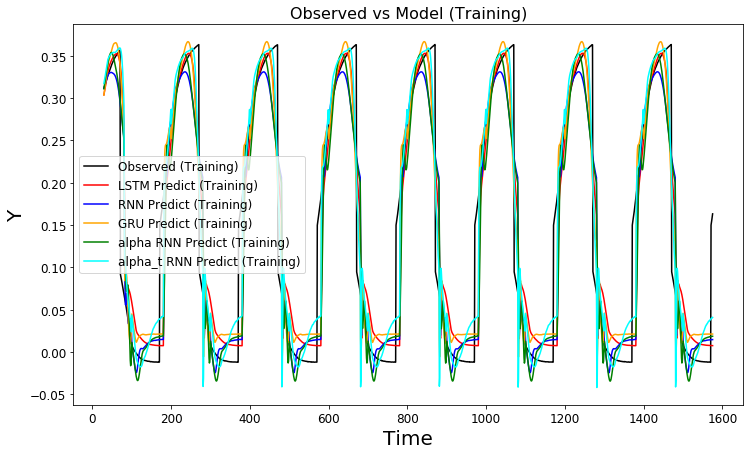

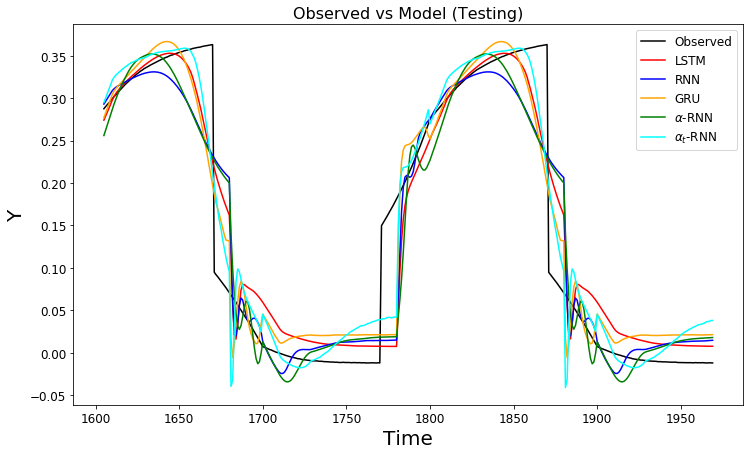

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], df_train[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], gru_pred_train[:, 0], color="orange", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], alpharnn_pred_train[:,0], color='green', label="alpha RNN Predict (Training)")
#train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], alpharnn_pred_train[:,0], color="yellow", label="alpha RS RNN Predict (Training)" )
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], alpharnnt_pred_train[:,0], color="cyan", label="alpha_t RNN Predict (Training)") 

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], df_test[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], lstm_pred_test[:, 0], color="red", label="LSTM")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], rnn_pred_test[:, 0], color="blue", label="RNN")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], gru_pred_test[:, 0], color="orange", label="GRU")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], alpharnn_pred_test,color="green", label="$\\alpha$-RNN")
#test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], alpharnn_pred_test, color="yellow", label= "alpha RS RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], alpharnnt_pred_test[:,0], color="cyan", label="$\\alpha_t$-RNN")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

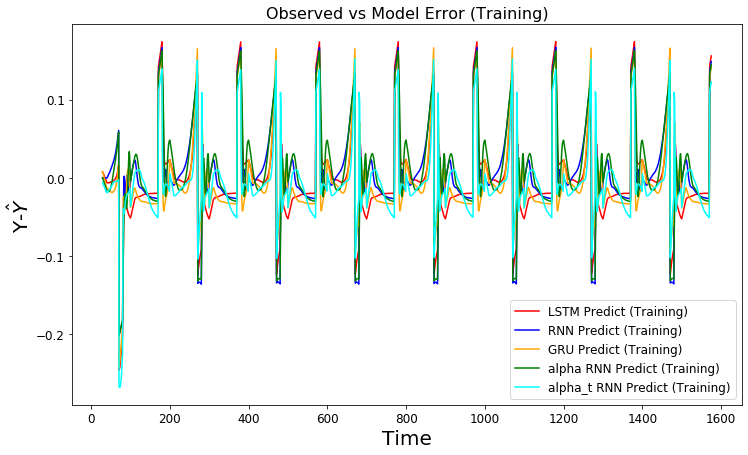

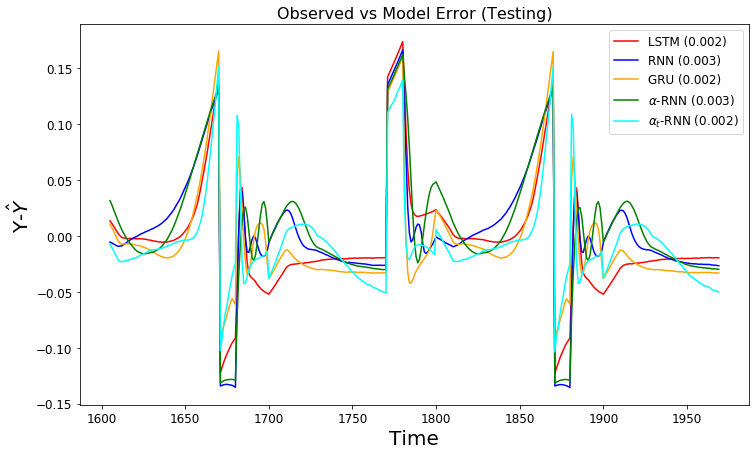

In [0]:
fig = plt.figure(figsize=(12,7))
#train_line_real = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], df_train[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], df_train[use_feature][n_steps+n_steps_ahead-1:]-lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], df_train[use_feature][n_steps+n_steps_ahead-1:]-rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], df_train[use_feature][n_steps+n_steps_ahead-1:]-gru_pred_train[:, 0], color="orange", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], df_train[use_feature][n_steps+n_steps_ahead-1:]-alpharnn_pred_train[:,0], color='green', label="alpha RNN Predict (Training)")
#train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], alpharnn_pred_train[:,0], color="yellow", label="alpha RS RNN Predict (Training)" )
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], df_train[use_feature][n_steps+n_steps_ahead-1:]-alpharnnt_pred_train[:,0], color="cyan", label="alpha_t RNN Predict (Training)") 

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y-$\hat{Y}$', fontsize=20)

fig = plt.figure(figsize=(12,7))
#test_line_real = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], df_test[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], df_test[use_feature][n_steps+n_steps_ahead-1:]-lstm_pred_test[:, 0], color="red", label="LSTM (" + str(round(MSE['test']['lstm'],3)) +")")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], df_test[use_feature][n_steps+n_steps_ahead-1:]-rnn_pred_test[:,0], color="blue", label="RNN (" + str(round(MSE['test']['rnn'],3)) +")")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], df_test[use_feature][n_steps+n_steps_ahead-1:]-gru_pred_test[:, 0], color="orange", label="GRU (" + str(round(MSE['test']['gru'],3)) +")")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], df_test[use_feature][n_steps+n_steps_ahead-1:]-alpharnn_pred_test[:,0],color="green", label="$\\alpha$-RNN (" +  str(round(MSE['test']['alpharnn'],3)) +")")
#test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], alpharnn_pred_test, color="yellow", label= "alpha RS RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps+n_steps_ahead-1:], df_test[use_feature][n_steps+n_steps_ahead-1:]-alpharnnt_pred_test[:,0], color="cyan", label="$\\alpha_t$-RNN (" + str(round(MSE['test']['alphatrnn'],3)) +")")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y-$\hat{Y}$', fontsize=20)

plt.show()